In [1]:
from omnigibson.maps import TraversableMap, SegmentationMap

In [2]:
import pathlib
scene_dirs = {p.name: p for p in pathlib.Path("/scr/og-docker-data/datasets/og_dataset").glob("scenes/*")}
print(scene_dirs)

{'Beechwood_1_int': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/Beechwood_1_int'), 'office_cubicles_left': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/office_cubicles_left'), 'Wainscott_1_int': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/Wainscott_1_int'), 'Benevolence_0_int': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/Benevolence_0_int'), 'Rs_garden': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/Rs_garden'), 'hall_train_station': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/hall_train_station'), 'office_large': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/office_large'), 'hotel_suite_large': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/hotel_suite_large'), 'grocery_store_half_stocked': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/grocery_store_half_stocked'), 'Ihlen_0_int': PosixPath('/scr/og-docker-data/datasets/og_dataset/scenes/Ihlen_0_int'), 'Pomaria_0_garden':

In [3]:
SELECTED_SCENE = "Beechwood_0_garden"
SELECTED_SCENE_DIR = scene_dirs[SELECTED_SCENE]

In [4]:
tm = TraversableMap(map_resolution=0.01, default_erosion_radius=0.35)
tm.load_map(str(SELECTED_SCENE_DIR / "layout"))
sm = SegmentationMap(scene_dir=str(SELECTED_SCENE_DIR), map_resolution=0.01)
sm.load_map()

In [15]:
import torch as th
import cv2

sem_map = sm.room_sem_map.cpu().numpy()
ins_map = sm.room_ins_map.cpu().numpy()
trav_map = cv2.imread(str(SELECTED_SCENE_DIR / "layout" / "floor_trav_no_door_0.png"), cv2.IMREAD_GRAYSCALE)

In [6]:
# Get the main connected component and make sure it covers all the rooms
import numpy as np

def get_main_cc(img):
  _, component_labels = cv2.connectedComponents(img, connectivity=4)
  components, counts = np.unique(component_labels, return_counts=True)
  counts_by_component = {k: v for k, v in zip(components, counts) if k != 0}
  max_size_component, max_size_component_size = max(counts_by_component.items(), key=lambda x: x[1])
  assert [k for k, v in counts_by_component.items() if v == max_size_component_size] == [max_size_component]
  return trav_map & (component_labels == max_size_component)

trav_map_main = get_main_cc(trav_map)

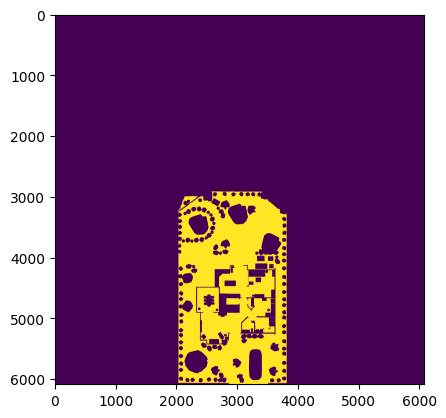

In [7]:
import matplotlib.pyplot as plt
plt.imshow(trav_map_main)
plt.show()

In [10]:
# Eroded trav map
import math
rad = 0.3
radius_pixel = int(math.ceil(rad / tm.map_resolution))
trav_map_eroded = cv2.erode(trav_map, np.ones((radius_pixel, radius_pixel)))
trav_map_eroded_main = get_main_cc(trav_map_eroded)

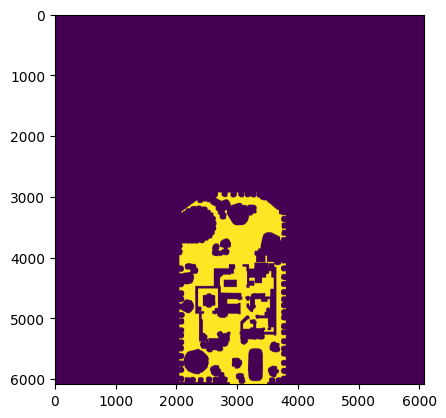

In [11]:
plt.imshow(trav_map_eroded_main)
plt.show()

In [16]:
# Dilated floor map
trav_map_dilated = cv2.dilate(trav_map_eroded_main, np.ones((radius_pixel, radius_pixel))) & trav_map_main

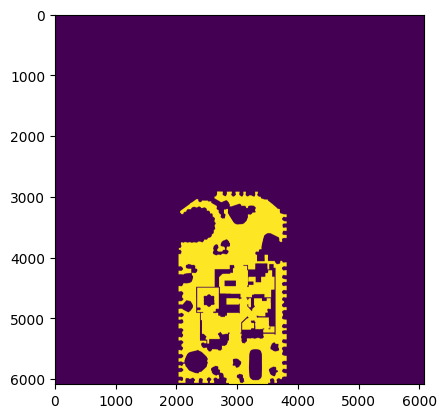

In [17]:
plt.imshow(trav_map_dilated)
plt.show()

In [ ]:
# Check that the rooms that are visible in the original map, the original map CC, and the eroded+dilated map CC are the same
rooms_in_original = set(np.unique(ins_map[trav_map == 1]))
rooms_in_original_main = set(np.unique(ins_map[trav_map_main == 1]))
rooms_in_eroded = set(np.unique(ins_map[trav_map_eroded == 1]))
rooms_in_eroded_main = set(np.unique(ins_map[trav_map_eroded_main == 1]))
rooms_in_dilated = set(np.unique(ins_map[trav_map_dilated == 1]))